# New York City Taxi Trip Duration Predicter

## 1: Set up PySpark and Imports

In [1]:
!pip install pyspark

In [2]:
#creating SparkSession
from pyspark.sql import *

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
spark

In [4]:
# imports
from google.colab import drive
from math import radians, sin, cos, sqrt, atan2
from pyspark.sql.functions import col, udf, date_format, to_timestamp, year, month, hour, dayofweek
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 2: Upload Data Files

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_file_path = '/content/drive/My Drive/SENG 550 - Group Project/train.csv'
import os
with open(train_file_path, 'r') as file:
  content = file.read()

In [7]:
#read in training csv file
df = spark.read.csv(train_file_path, header=True, inferSchema=True)
df.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

## 3: Dataset Cleaning & Preparation

### Data Cleaning
Removing fields that are not needed for analysis and removing NaN and Null values

In [8]:
# drop unused data columns
df = df.drop(df.id)
df = df.drop(df.store_and_fwd_flag)

In [9]:
# drop NaN and Null Values
df = df.na.drop()

## Data Preparation
Creating columns for additional calculated fields, including Distance Travelled, Average Speed, and splitting the 'pickup_datetime' field into Year, Month, Weekday, and Hour





In [10]:

# calculate distance in km
def calculate_distance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    def toRadians(value):
      return radians(float(value))

    latitude1 = toRadians(pickup_latitude)
    latitude2 = toRadians(dropoff_latitude)
    longitude1 = toRadians(pickup_longitude)
    longitude2 = toRadians(dropoff_longitude)

    latitude_difference = latitude2 - latitude1
    longitude_difference = longitude2 - longitude1

    # Haversine formula
    a = sin(latitude_difference / 2)**2 + cos(latitude1) * cos(latitude2) *sin(longitude_difference / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return c * 6371

distance_udf = udf(calculate_distance, DoubleType())

df = df.withColumnRenamed("trip_duration", "trip_duration_s")
df = df.withColumn("distance_travelled_km", distance_udf(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude))

In [11]:
# split pickup_datetime into day of the week, month, and hour
def get_day_of_week(datetime):
  return date_format(to_timestamp(datetime, 'yyyy-MM-dd HH:mm:ss'), 'E')

df = df.withColumn("day_of_week", get_day_of_week(df.pickup_datetime)) \
    .withColumn("month", month(df.pickup_datetime)) \
    .withColumn("hour", hour(df.pickup_datetime))
df = df.withColumn("day_of_week_index", dayofweek(df['pickup_datetime']))
df = df.drop(df.pickup_datetime)
df = df.drop(df.dropoff_datetime)

In [12]:
# calculate average speed in km/h
def get_avg_speed(distance, time):
  time_in_hours = time/3600
  return distance/time_in_hours

df = df.withColumn("avg_speed_kmh", get_avg_speed(df.distance_travelled_km, df.trip_duration_s))

In [13]:
df.show()

+---------+---------------+------------------+------------------+------------------+------------------+---------------+---------------------+-----------+-----+----+-----------------+------------------+
|vendor_id|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|trip_duration_s|distance_travelled_km|day_of_week|month|hour|day_of_week_index|     avg_speed_kmh|
+---------+---------------+------------------+------------------+------------------+------------------+---------------+---------------------+-----------+-----+----+-----------------+------------------+
|        2|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|            455|   1.4985207796469109|        Mon|    3|  17|                2|11.856428146656878|
|        1|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|            663|   1.8055071687958897|        Sun|    6|   0|                1| 9.8036588

### Outlier Removal
Checking for:
- coordinates outside of defined range (latitude: 40.591 to 40.927; longitude: -74.880 to -73.297)
- trip duration outside of defined range (120 seconds to 11412 seconds)
- trip distance outside of defiend range (0.805 km to 77.088 km)
- average speeds greater than 104 kilometers per hour (65 miles per hour)

In [14]:
def filterLat(df, latitude):
  return df.filter((latitude >= 40.591) & (latitude <= 40.927))

def filterLong(df, longitude):
  return df.filter((longitude >= -74.880) & (longitude <= -73.297))

df = filterLat(df, df.pickup_latitude)
df = filterLat(df, df.dropoff_latitude)
df = filterLong(df, df.pickup_longitude)
df = filterLong(df, df.dropoff_longitude)

In [15]:
df = df.filter((df.trip_duration_s >= 120) & (df.trip_duration_s <= 11412))
df = df.filter((df.distance_travelled_km >= 0.805) & (df.distance_travelled_km <= 77.088))

In [16]:
df = df.filter((df.avg_speed_kmh <= 104))

In [17]:
df.show()

+---------+---------------+------------------+------------------+------------------+------------------+---------------+---------------------+-----------+-----+----+-----------------+------------------+
|vendor_id|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|trip_duration_s|distance_travelled_km|day_of_week|month|hour|day_of_week_index|     avg_speed_kmh|
+---------+---------------+------------------+------------------+------------------+------------------+---------------+---------------------+-----------+-----+----+-----------------+------------------+
|        2|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|            455|   1.4985207796469109|        Mon|    3|  17|                2|11.856428146656878|
|        1|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|            663|   1.8055071687958897|        Sun|    6|   0|                1| 9.8036588

## 4: Machine Learning Models

In [18]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, Interaction
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [19]:
df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- trip_duration_s: integer (nullable = true)
 |-- distance_travelled_km: double (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week_index: integer (nullable = true)
 |-- avg_speed_kmh: double (nullable = true)



In [20]:
input_columns  = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance_travelled_km', 'day_of_week_index', 'hour', 'passenger_count']
assembler = VectorAssembler(
    inputCols = input_columns,
    outputCol ="features"
)

input_column = assembler.transform(df)
input_column.select("features").show()
final_df = input_column.select("features", "trip_duration_s")
final_df.show()

+--------------------+
|            features|
+--------------------+
|[-73.982154846191...|
|[-73.980415344238...|
|[-73.979026794433...|
|[-74.010040283203...|
|[-73.973052978515...|
|[-73.982856750488...|
|[-73.969017028808...|
|[-73.969276428222...|
|[-73.999481201171...|
|[-73.981048583984...|
|[-73.982650756835...|
|[-73.991531372070...|
|[-73.962982177734...|
|[-73.956306457519...|
|[-73.992195129394...|
|[-73.991165161132...|
|[-73.994255065917...|
|[-74.003982543945...|
|[-73.98388671875,...|
|[-73.980369567871...|
+--------------------+
only showing top 20 rows

+--------------------+---------------+
|            features|trip_duration_s|
+--------------------+---------------+
|[-73.982154846191...|            455|
|[-73.980415344238...|            663|
|[-73.979026794433...|           2124|
|[-74.010040283203...|            429|
|[-73.973052978515...|            435|
|[-73.982856750488...|            443|
|[-73.969017028808...|            341|
|[-73.969276428222...|          

## 4.1: Linear Regression Model
Uses cross validation

In [21]:
train_data, test_data = final_df.randomSplit([0.8, 0.2])

linear_regression = LinearRegression(featuresCol = "features", labelCol = "trip_duration_s")

linear_regression_param_grid = ParamGridBuilder() \
                                .addGrid(linear_regression.regParam, [0.01, 0.1, 0.5, 1.0, 2.0]) \
                                .addGrid(linear_regression.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
                                .addGrid(linear_regression.maxIter, [10, 50, 100]) \
                                .addGrid(linear_regression.fitIntercept, [True, False]) \
                                .build()

regression_evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "trip_duration_s", metricName = "rmse")

cross_validator = CrossValidator(estimator = linear_regression,
                      estimatorParamMaps = linear_regression_param_grid,
                      evaluator = regression_evaluator,
                      numFolds = 5)

In [22]:
model = cross_validator.fit(train_data)

In [23]:
print("Best Regularization Parameter (lambda): ", model.bestModel._java_obj.getRegParam())
print("Best Elastic Net Parameter (weight, w): ", model.bestModel._java_obj.getElasticNetParam())
print("Best maxIter Parameter (learning rate, alpha): ", model.bestModel._java_obj.getMaxIter())
print("Best fitIntercept Parameter (y-intercept): ", model.bestModel._java_obj.getFitIntercept())
print("Intercept (y-intercept): ", model.bestModel.intercept)

# Acuracy and coefficients of the linear equation.
print("Coefficient of Determination (Accuracy on Training data): ", str(round(model.bestModel.summary.r2*100, 2)), "%")
print("Coefficients: ", model.bestModel.coefficients)

Best Regularization Parameter (lambda):  0.01
Best Elastic Net Parameter (weight, w):  0.0
Best maxIter Parameter (learning rate, alpha):  10
Best fitIntercept Parameter (y-intercept):  True
Intercept (y-intercept):  -100294.81327081968
Coefficient of Determination (Accuracy on Training data):  59.16 %
Coefficients:  [-484.87569028893034,1010.3589464896365,-1004.9597144076522,-1246.7266102095377,133.1829418793526,13.203354265629205,4.472414908824625,2.26614958098137]


In [24]:
prediction = model.transform(test_data)
prediction.show(10)
# Note: Final dataset has 259646 rows

+--------------------+---------------+------------------+
|            features|trip_duration_s|        prediction|
+--------------------+---------------+------------------+
|[-74.141441345214...|            899|3004.9603303838667|
|[-74.084587097167...|            140| 809.8423275079404|
|[-74.052406311035...|            513|1508.2392196736764|
|[-74.041404724121...|            539| 579.8860665425454|
|[-74.037277221679...|            879|1988.8681254769763|
|[-74.036529541015...|           1506|1517.5235829910816|
|[-74.032600402832...|           1334|2384.2926782430586|
|[-74.031219482421...|            142| 636.4906419294566|
|[-74.028800964355...|            484| 596.5815758764656|
|[-74.028022766113...|           1959|1864.8369801248919|
+--------------------+---------------+------------------+
only showing top 10 rows



In [25]:
test_pred_evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "trip_duration_s", metricName = "r2")

print("Root Mean Squared Error (RMSE): ", regression_evaluator.evaluate(prediction))
print("Coefficient of Determination (Accuracy on Test Data): ", str(round(test_pred_evaluator.evaluate(prediction)*100, 4)), "%")

Root Mean Squared Error (RMSE):  423.1510355881273
Coefficient of Determination (Accuracy on Test Data):  58.9697 %


## 4.2: Gradient Boosted Tree Model

In [26]:
gbtr = GBTRegressor(featuresCol="features", labelCol="trip_duration_s")

gradient_boosted_trees_param_grid = ParamGridBuilder() \
                                    .addGrid(gbtr.maxDepth, [5, 10]) \
                                    .addGrid(gbtr.maxIter, [5, 10, 20]) \
                                    .addGrid(gbtr.maxBins, [32, 64]) \
                                    .build()

gbt_evaluator = RegressionEvaluator(labelCol="trip_duration_s", predictionCol="prediction", metricName="rmse")

cross_validator_gbtr = CrossValidator(estimator = gbtr,
                       estimatorParamMaps = gradient_boosted_trees_param_grid,
                       evaluator = gbt_evaluator,
                       numFolds = 5)

In [27]:
model_gbtr = cross_validator_gbtr.fit(train_data)

In [28]:
predictions = model_gbtr.transform(test_data)
evaluator = RegressionEvaluator(labelCol="trip_duration_s", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 317.159


In [29]:
evaluator = RegressionEvaluator(labelCol="trip_duration_s", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"r^2 = {r2*100}%")

r^2 = 76.64833873385413%


In [ ]:
best_model = model_gbtr.bestModel._java_obj
best_depth = best_model.getMaxDepth()
best_bins = best_model.getMaxBins()
best_max_iter = best_model.getMaxIter()
best_impurity = best_model.getImpurity()
best_loss_type = best_model.getLossType()

print(f"Best Max Depth Parameter: {best_depth}")
print(f"Best Max Bins Parameter: {best_bins}")
print(f"Best Max Iter Parameter: {best_max_iter}")
print(f"Best Impurity Parameter: {best_impurity}")
print(f"Best LossType Parameter: {best_loss_type}")

Best Max Depth Parameter: 10
Best Max Bins Parameter: 32
Best Max Iter Parameter: 20
Best Impurity Parameter: variance
Best LossType Parameter: squared


## 4.3 Random Forest Regression With Polynomial Expansion (NO CV Because of Heap memory issues)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_duration_s', numTrees=10, maxDepth=5)

# Train the Random Forest model
rf_model = rf.fit(train_data)

# Evaluate the model on test data
predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="trip_duration_s", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 392.783


In [ ]:
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trip_duration_s", metricName="r2")
mse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trip_duration_s", metricName="mse")

r2 = r2_evaluator.evaluate(predictions)
mse = mse_evaluator.evaluate(predictions)

print(f"R^2 (coefficient of determination) on test data: {r2}")
print(f"Mean Squared Error (MSE) on test data: {mse}")

R^2 (coefficient of determination) on test data: 0.6396301550290386
Mean Squared Error (MSE) on test data: 154278.8693234131


# 5: Data Visualization

In [33]:
day_of_week = 'day_of_week'
avg_speed = 'avg_speed_kmh'
hour = 'hour'
distance = 'distance_travelled_km'
month = 'month'

### Hourly Average Speed

<ipython-input-34-7a976661563e>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = hourly_average_speed.pivot(day_of_week, hour, 'avg(avg_speed_kmh)')


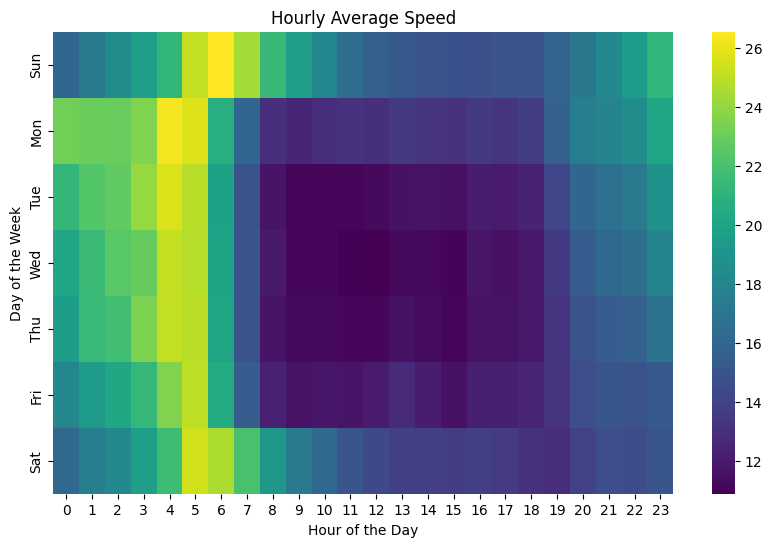

In [34]:
custom_weekday_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

hourly_average_speed = df.groupby(day_of_week, hour) \
  .avg(avg_speed) \
  .orderBy(day_of_week, hour) \
  .toPandas()

heatmap_data = hourly_average_speed.pivot(day_of_week, hour, 'avg(avg_speed_kmh)')
heatmap_data = heatmap_data.reindex(custom_weekday_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Hourly Average Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

### Speed vs. Distance

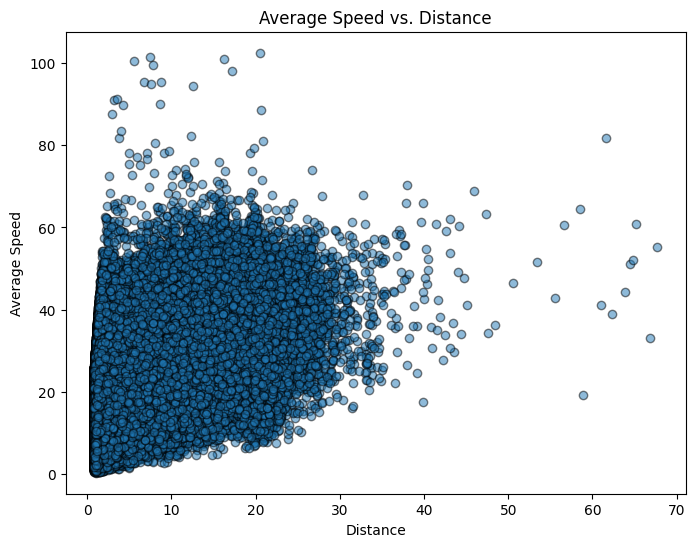

In [35]:
speed_distance = df.select(avg_speed, distance).toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(speed_distance[distance], speed_distance[avg_speed], alpha=0.5, edgecolors='black')
plt.title('Average Speed vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Average Speed')
plt.show()

### Average Speed per Month

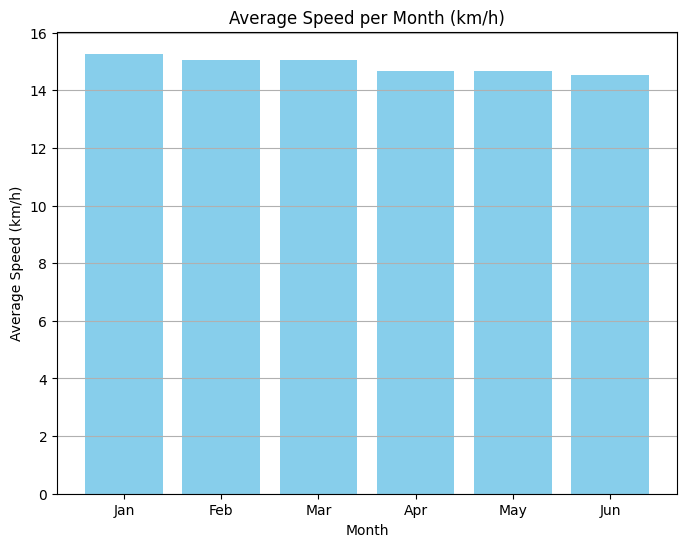

In [36]:
avg_speed_per_month = df.groupBy(month) \
  .avg(avg_speed) \
  .orderBy(month) \
  .toPandas()

# Note: Data from August - December was blank, so they were omitted from the axis
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
months = np.arange(1, 7)

plt.figure(figsize=(8, 6))
plt.bar(avg_speed_per_month['month'], avg_speed_per_month['avg(avg_speed_kmh)'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed per Month (km/h)')
plt.xticks(months, month_labels)
plt.grid(axis = 'y')
plt.show()

### Comparing the Spread of Data Between the Model and Test Data

In [37]:
# Converting the output from the model to a Pandas object
model_output = prediction.toPandas()

Text(0.5, 1.0, 'Data Spread for Test Data')

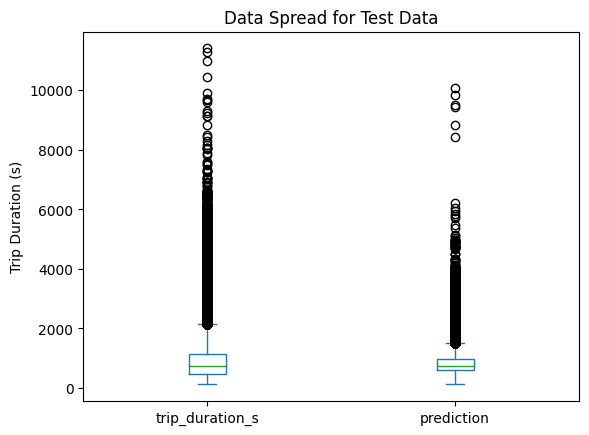

In [38]:
boxplot_for_model = model_output.plot.box()
boxplot_for_model.set_ylabel("Trip Duration (s)")
boxplot_for_model.set_title("Data Spread for Test Data")